<a href="https://colab.research.google.com/github/eshghinezhad/ML_Classifire_Student_Success/blob/master/Student_Success_Classifires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Assignment 2- Building Classifiers** ---------- **Monireh Eshghinezhad**
> #

In [2]:
import numpy as np
import pandas as pd

##  **Data Loading and Initial Cleaning** (Brief EDA)

In [3]:
student=pd.read_csv("MAI101 W26 A1 data v0.1.csv")

Base on the assignment1, the dataset contains 1,677 **rows** and 17 **columns**.
Several variables contain **missing** values.
The Business101Grade variable includes values **outside** the expected **range** (>100).
The status variable contains **invalid categories** ('S', 'X', 'V2'). Some column names contain spaces.

####Before proceeding with modeling, basic data cleaning was performed:

1.   Renamed columns to remove spaces.
2.   Kept only valid status values ('D', 'I').
3.   Removed records where Business101Grade exceeded 100.
4.   Reset the index after filtering.

## **Structural Fix:**

In [4]:
#assign the appropriate name for some features
student = student.rename(columns={
 "Math101 Grade": "Math101Grade",
 "Business101 Grade": "Business101Grade",
 "Overall Average Grade": "OverallAverageGrade"
})
# keeps only valid status.
valid_status = ['D', 'I']
student = student[student['status'].isin(valid_status)]
# keeps only valid Business101Grade
student = student[student['Business101Grade'] <= 100 ]

# creates a new index & Do not keep the old index as a separate column.
student = student.reset_index(drop=True)

## **Create the Target Variable**:
### Create the new column '**on_schedule**' (1 or 0) base on '**duration**' and '**totalSemesters**'

In [5]:
student['onSchedule'] = ((student.hasGraduated == 1) &
(student.totalSemesters <= (student.duration * 2 + 2))).astype(int)

## **Analyze Target Variable - Class Balance and Class Relationships:**

In [6]:
# Show the number and proportion of each class in target variable.
print(student.onSchedule.value_counts())
print("-"*50)
print (student["onSchedule"].value_counts(normalize=True))

onSchedule
0    1037
1     618
Name: count, dtype: int64
--------------------------------------------------
onSchedule
0    0.626586
1    0.373414
Name: proportion, dtype: float64


### The target variable shows a **moderate class imbalance**. Approximately 63% of students did not graduate on schedule, while 37% graduated on schedule.
> #### Because of this imbalance, evaluation metrics beyond overall accuracy, such as **precision**, **recall**, and  
**F1-score**, will be considered to properly **assess model performanc**e.

In [7]:
 # Show the relationship between the target variable and other features
display(student.groupby("onSchedule")["OverallAverageGrade"].mean())
display(pd.crosstab(student["status"], student["onSchedule"]))
display(pd.crosstab(student["gender"], student["onSchedule"]))
display(pd.crosstab(student["transfer_in"], student["onSchedule"]))
display(pd.crosstab(student["Mature"], student["onSchedule"]))

,OverallAverageGrade
onSchedule,
0,67.727896
1,79.663533


onSchedule,0,1
status,,
D,780,456
I,257,162


onSchedule,0,1
gender,,
F,366,249
M,671,369


onSchedule,0,1
transfer_in,,
0,734,329
1,303,289


onSchedule,0,1
Mature,,
0,541,235
1,496,383


## **`Feature` and `Target` separation**

In [8]:
numerical_features = ['duration', 'LangTestPercent','MathTestPercent',
                      'AptitudeTestPercent', 'transfer_in', 'Business101Grade',
                      'Mature']
categorical_features = ['program', 'status', 'gender', 'Math101Grade']

x = student[numerical_features + categorical_features]
y = student["onSchedule"]

## **Split dataset** into **Training(60%)**, **Validation(20%)** and **Test(20%)** sets
#####The data was split using a fixed random state for reproducibility and stratification to preserve the class distribution in both training and testing sets.

In [9]:
from sklearn.model_selection import train_test_split

# 1. Split into (Train + Val)(80%) and Test(20%)           random_state=10: generating same training and testing sets each time the code is run.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, random_state=10, stratify=y
)

# 2. Split (Train + Val) into separate Train(60%) and Validation(20%) sets      stratify=y: keeps the class distribution consistent.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=10, stratify=y_train_val
)

## Build the **ColumnTransformer** and **Pipeline**
Apply different transformations to different columns.
| Column Type   | Transformation       |
|---------------|----------------------|
| Numeric       |  **Median** + **Scaling**    |
| Categorical   |  **OneHotEncode**        |

In [10]:
from sklearn.compose import ColumnTransformer   # we have mixed columns(numeric + categorical). we need apply different transformations to different columns.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Define the pipelines for each type of feature
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Fills missing with median
    ('scaler', StandardScaler())                    # Scales the numericals for distance-based algorithms (KNN, SVM) is required.
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handles new categories in test set
])

# 2. Combine them into one ColumnTransformer
full_prep = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

###  **Variable Issues & Steps Report**

| Variable Name    |	Issue Identified	       |  Step/Transformation Applied    |
|------------------|--------------------------|---------------------------------|
| onSchedule       | Not explicitly in dataset|Create the new column,using hasGraduated and totalSemesters columns.
| Numeric Features | Missing values, different scales|Imputed using median strategy, then standardized (Z-score scaling)|
|Categorical Features| Text values need numeric representation|One-Hot Encoding applied to convert categories to binary features|

####To prevent data leakage, all **imputation** and **scaling** parameters were derived exclusively from the training data (X_train and y_train) and then applied using a **ColumnTransformer** within the **pipelines**. Also applied stratification during the train, validation, and test split to maintain the class distribution ratio (63% / 37%) across all three sets.

# **Building KNN Model**


In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

knn_model = make_pipeline(full_prep, KNeighborsClassifier())   # Builds a model structure.-> n_neighbors = 5 (default value)
knn_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration',
                                                   'LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'status',
                                                   'gender',
                                                   'Math101Grade'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

## Analize KNN Model by using different  K


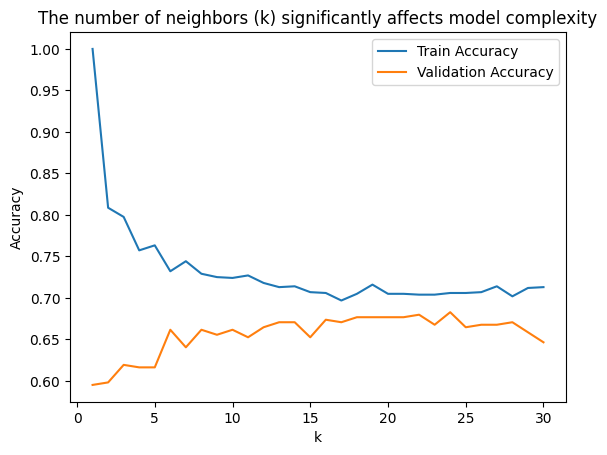

In [20]:
import matplotlib.pyplot as plt
train_scores = []
Validation_scores = []
k_values = range(1, 31)
for k in k_values:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train)

    train_scores.append(knn_model.score(X_train, y_train))
    Validation_scores.append(knn_model.score(X_val, y_val))

plt.plot(k_values, train_scores, label="Train Accuracy")
plt.plot(k_values,Validation_scores, label="Validation Accuracy")
plt.title("The number of neighbors (k) significantly affects model complexity")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

  # **Accuracy** alone would **mislead** toward majority class.

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

for k in [1, 15, 50]:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train)

    y_train_pred = knn_model.predict(X_train)
    y_validation_pred = knn_model.predict(X_val)

    print(f"k = {k}")
    print("Train Accuracy:", accuracy_score(y_train, y_train_pred)  ,
    "    ----  Test Accuracy :", accuracy_score(y_val, y_validation_pred))

    print(classification_report(y_val, y_validation_pred, target_names=['Class 0', 'Class 1']))
    print("-" * 40)

k = 1
Train Accuracy: 1.0     ----  Test Accuracy : 0.595166163141994
              precision    recall  f1-score   support

     Class 0       0.67      0.68      0.68       207
     Class 1       0.46      0.45      0.46       124

    accuracy                           0.60       331
   macro avg       0.57      0.57      0.57       331
weighted avg       0.59      0.60      0.59       331

----------------------------------------
k = 15
Train Accuracy: 0.7069486404833837     ----  Test Accuracy : 0.6525679758308157
              precision    recall  f1-score   support

     Class 0       0.69      0.80      0.74       207
     Class 1       0.55      0.41      0.47       124

    accuracy                           0.65       331
   macro avg       0.62      0.60      0.61       331
weighted avg       0.64      0.65      0.64       331

----------------------------------------
k = 50
Train Accuracy: 0.6998992950654582     ----  Test Accuracy : 0.6918429003021148
              precis

### **k = 1**

  #### - Perfect training accuracy → severe **overfitting**

  #### - Low test accuracy → **poor generalization**
### **Medium k (10–25)**

  #### - Train and test curves closer

  #### - Best test performance (~0.67–0.69)

  #### - Best **generalization**

### **Very large k**

  #### - Both train and test accuracy flatten

  #### - Slight **underfitting** beginning


### Although accuracy slightly increased as k became larger, the F1-score for the **minority class** showed a **different trend**.
### While k=50 achieved the highest accuracy (≈0.67), its recall for students graduating on schedule dropped significantly, reducing its F1-score. In contrast, k=15 provided a better balance between precision and recall for the minority class. Given the **moderate class imbalance** (63% vs 37%), **F1-score** was considered a **more reliable metric**, and k=15 was preferred than 50

## **Tune Hyperparameter** :  GridSearchCV for kNN (Tune **n_neighbors** and **weights**)

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 31)),
    'kneighborsclassifier__weights': ['uniform', 'distance']
}
# Use GridSearchCV to find the best parameter 'k' using the training+validation data
grid_knn = GridSearchCV(knn_model, param_grid, cv=5, scoring='f1', n_jobs=-1) # Use F1 score because of the slight class imbalance

# Fit the grid search to the combined training/validation data
grid_knn.fit(X_train_val, y_train_val)

print("Best parameters found:", grid_knn.best_params_)  # The specific combination of hyperparameters that achieved the highest F1 score.
print(f"Best cross-validation F1 score: {grid_knn.best_score_:.2f}")  # The mean cross-validated score (F1) of the best parameter set.

Best parameters found: {'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__weights': 'uniform'}
Best cross-validation F1 score: 0.52


## Hyperparameter tuned using GridSearchCV (5-fold cross-validation)
### * Best k = 13    ->  The optimal number of neighbors is 13.
### * Best weighting = uniform -> Distance does NOT matter, majority wins
### * Best cross-validated F1-score = 0.52  ->  indicating improved balance between precision and recall for the minority class.

# Visualizing F1 Score vs. K-Neighbors for both **uniform** and **distance** weighting

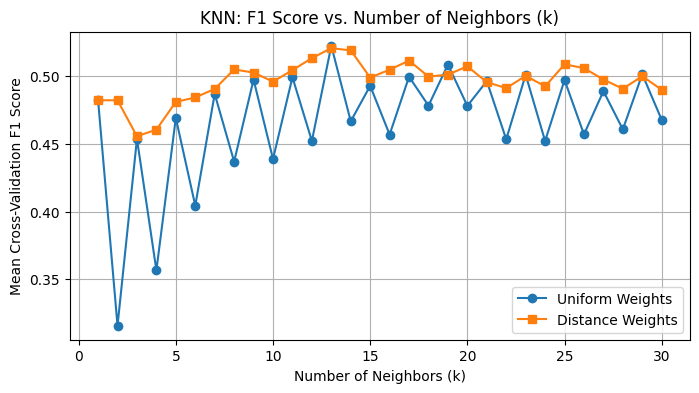

In [15]:
# 1. Convert cv_results_ to a pandas DataFrame
results_df = pd.DataFrame(grid_knn.cv_results_)

# 2. Filter results for each weight type
uniform_results = results_df[results_df['param_kneighborsclassifier__weights'] == 'uniform']
distance_results = results_df[results_df['param_kneighborsclassifier__weights'] == 'distance']

# 3. Plotting
plt.figure(figsize=(8, 4))
plt.plot(uniform_results['param_kneighborsclassifier__n_neighbors'],
         uniform_results['mean_test_score'], label='Uniform Weights', marker='o')
plt.plot(distance_results['param_kneighborsclassifier__n_neighbors'],
         distance_results['mean_test_score'], label='Distance Weights', marker='s')

plt.title('KNN: F1 Score vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()

###Performance improved from very small k values and then stabilized, with the strongest results occurring around k ≈ 10–20, showing that **moderate k** values provide the **best balance** between overfitting (small k) and underfitting (large k).

# **Final Evaluation** on Test Set

Test Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       207
           1       0.56      0.49      0.53       124

    accuracy                           0.67       331
   macro avg       0.64      0.63      0.64       331
weighted avg       0.66      0.67      0.66       331

Test Confusion Matrix:
[[160  47]
 [ 63  61]]


<Figure size 800x600 with 0 Axes>

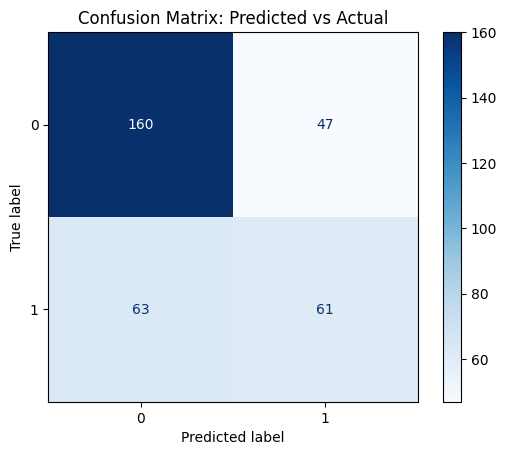

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_knn = grid_knn.best_estimator_

y_test_pred = best_knn.predict(X_test)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(grid_knn, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix: Predicted vs Actual')
plt.show()

Using the tuned kNN model, final evaluation on the held-out test set produced accuracy ≈ 0.67 and F1 (onSchedule=1) ≈ 0.53. The confusion matrix shows the model correctly identified 61 on-schedule students, while missing 63 (false negatives), indicating reasonable performance but with room to improve recall for the on-schedule class.

# Comparison: Tuned vs. Untuned kNN

The untuned kNN model (default k=5) achieved moderate performance but was not optimized for class balance. After hyperparameter tuning using cross-validation, the tuned model (k=13, uniform weights) **improved the F1-score** for the minority class while maintaining similar overall accuracy. This demonstrates that **systematic hyperparameter tuning provides better balance** between precision and recall compared to using default settings.

# **Building Logistic Regression Model**

In [25]:
from sklearn.linear_model import LogisticRegression

logReg_model = Pipeline([
    ("prep", full_prep),               #liblinear: supports L1 (Lasso) regularization, which automatically perform feature selection.
    ("LogRegClf", LogisticRegression(max_iter=500, solver="liblinear"))  # stable for small/medium data
])

logReg_model


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration',
                                                   'LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'status',
                                                   'gender',
                                                   'Math101Grade'])])),
                ('clf', LogisticRegression(max_iter=500, solver='liblinear'))])

## Train + Validation evaluation (before tuning)

In [31]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

logReg_model.fit(X_train, y_train)   #Train the model

y_val_pred = logReg_model.predict(X_val)

print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred):.2f}")
print("Validation F1      :", f"{f1_score(y_val, y_val_pred):.2f}")
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['0-not onSchedule', '1-onSchedule']))


Validation Accuracy: 0.67
Validation F1      : 0.51
Confusion matrix:
 [[163  44]
 [ 66  58]]
                  precision    recall  f1-score   support

0-not onSchedule       0.71      0.79      0.75       207
    1-onSchedule       0.57      0.47      0.51       124

        accuracy                           0.67       331
       macro avg       0.64      0.63      0.63       331
    weighted avg       0.66      0.67      0.66       331



## **Model Performance Report** (before tuning)
### The model currently shows a **bias** toward the **majority class** ('not onSchedule'). Because the dataset is imbalanced, the model has learned the characteristics of class 0 more effectively than class 1, leading to a **high rate of False Negatives** for the 'onSchedule' category